In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import numpy as np
import pylab as plt
import pandas as pd
import seaborn as sns
from astropy.io import fits
from astropy import units as u
from sklearn.metrics import r2_score
from astropy import wcs, coordinates
from matplotlib.colors import LogNorm
from scipy.ndimage import gaussian_filter 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    gag = [x.name for x in local_device_protos if x.device_type == 'GPU']
    print(gag)

    if tf.test.gpu_device_name(): 
        print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
    else:
        print("Please install GPU version of TF")

def make_gen(x):
    def gen():
      i = 0
      while(i<len(x)):
        yield next(x)
        i +=1
    return gen

def add_noise(img,sigma=0.01):
    '''Add random noise to an image'''
    deviation = sigma*np.random.uniform(0,1)
    noise = np.random.normal(0, sigma, img.shape)
    img += noise
    np.clip(img, 0., 1.)
    return img

def smear(data,axis,ds):
    n_time = data.shape[axis]
    nt = int(n_time//ds)
    sdata = np.array(np.split(data, nt, axis=axis))
    return np.mean(sdata,axis=axis+1)

def get_patch(shape,axis,sigma0=0.7,muu=0,c=1):
#     nx,ny,nz = shape
    shape = list(shape)
    nr = shape[axis]
    shape.remove(nr)
    ny,nx = shape
    x, y = np.meshgrid(np.linspace(-1,1,nx), np.linspace(-1,1,ny))
    dst = np.sqrt(x*x+y*y)
    # Intializing sigma and muu
    gpatch = []
    for z in np.linspace(-.5,.5,nr):
        sigma = sigma0-np.abs(z)
        gauss = np.exp(-( (dst-muu)**2 / ( 2.0 * sigma**2 ) ) )
        gpatch.append(gauss)

    gpatch = np.stack(gpatch,axis=axis)
    gpatch = gpatch-gpatch.min()
    gpatch = gpatch/gpatch.max()
    return c*gpatch

def get_slice(data,label,nx,ny,nz):
    lx,ly,lz = data.shape  
    if nx==0 or nx==lx:
        slx = slice(0, lx)                
    else:
        idx = np.random.randint(0, lx - nx)            
        slx = slice(idx, (idx+nx))       
    if ny==0 or ny==ly:
        sly = slice(0, ly)                
    else:
        idy = np.random.randint(0, ly - ny)            
        sly = slice(idy, (idy+ny))
    if nz==0 or nz==ly:
        slz = slice(0, lz)                
    else:
        idz = np.random.randint(0, lz - nz)            
        slz = slice(idz, (idz+nz))
    return data[slx, sly, slz],label[slx, sly, slz]

def SimpleConv(shape=(28, 28, 1),n_class=1,fgrow=1):
    nd1,nd2,nch = shape
    input_img = keras.Input(shape=shape)

    nch *= fgrow
    x1 = layers.Conv2D(nch, (3, 3), activation='relu', padding='same')(input_img)
    x2 = layers.Conv2D(nch, (3, 3), activation='relu', padding='same')(x1)
    nch *= fgrow
    x3 = layers.Conv2D(nch, (3, 3), activation='relu', padding='same')(x2)
    nch *= fgrow
    x4 = layers.Conv2D(nch, (3, 3), activation='relu', padding='same')(x3)
    nch /= fgrow
    x5 = layers.Conv2D(nch, (3, 3), activation='relu', padding='same')(x4)
    x5 = x3+x5
    nch /= fgrow
    x6 = layers.Conv2D(nch, (3, 3), activation='relu', padding='same')(x5)
    decoded = layers.Conv2D(n_class, (3, 3), activation='tanh', padding='same')(x6)

    model = keras.Model(input_img, decoded)
    return model

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
get_available_gpus()

['/device:GPU:0']
Default GPU Device:/device:GPU:0


In [4]:
ls ~/scratch/ska/development/

cont_dev.fits  README_dev.txt  sky_dev_truthcat_v2.txt  sky_dev_v2.fits


### Loading the data, __sky__ is 21cm cube and __cont__ is continuum image and catalogue.

In [6]:
data_path = '/home/vafaeisa/scratch/ska/'

In [7]:
sky = fits.open(data_path+'development/sky_dev_v2.fits')
# cont = fits.open(data_path+'development/cont_dev.fits')


In [28]:
header = sky[0].header
sources = pd.read_csv(data_path+'development/sky_dev_truthcat_v2.txt',delimiter=' ')
sources = sources.sort_values('line_flux_integral',ascending=0).reset_index()

dfreq = header['CDELT3']
freq0 = header['CRVAL3']
# # frequency list in the HI cube
nf,nx,ny = sky[0].data.shape
freqs = np.arange(freq0,freq0+nf*dfreq,dfreq)
fqmhz = freqs/1e6

coord_sys = wcs.WCS(header)
ra, dec = sources['ra'],sources['dec']
num_sources = len(ra)
radec_coords = coordinates.SkyCoord(ra=ra, dec=dec, unit='deg', frame='fk5')
coords_ar = np.vstack([radec_coords.ra*u.deg, radec_coords.dec*u.deg,
                         np.zeros(num_sources)]).T
xy_coords = coord_sys.wcs_world2pix(coords_ar, 0)
x_coords, y_coords = xy_coords[:,0], xy_coords[:,1]
f_coordsf = sources['central_freq']

flux_inds = np.argsort(sources['line_flux_integral'].values)[::-1]

In [9]:
delta = 1
psky = sky[0].data
# smoothed_sky = gaussian_filter(sky[0].data,sigma=(3,3,5))
psky.shape

(6668, 643, 643)

(21, 21, 51)
(21, 21, 51)


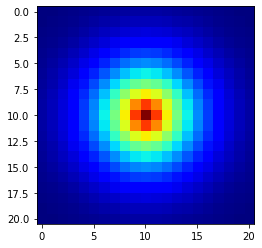

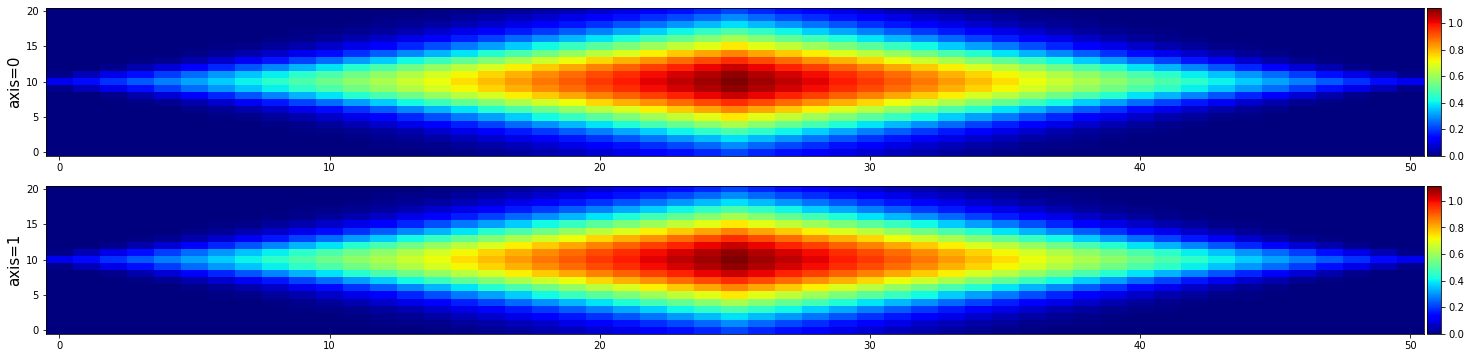

In [11]:
nx = 21
ny = 21
nz = 51

print((nx,ny,nz))
gpatch = get_patch((nx,ny,nz),axis=2,sigma0=0.55,muu=0,c=1.8)
print(gpatch.shape)
plt.imshow(np.mean(gpatch,axis=2),cmap='jet')

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(25,6))

im = ax1.imshow(np.mean(gpatch,axis=0),aspect='auto',cmap='jet',origin='lower')
# ax1.set_xticks([])
ax1.set_ylabel('axis=0',fontsize=15)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='1%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


im = ax2.imshow(np.mean(gpatch,axis=1),aspect='auto',cmap='jet',origin='lower')
# ax2.set_xticks([])
ax2.set_ylabel('axis=1',fontsize=15)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='1%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

(121, 11, 11)


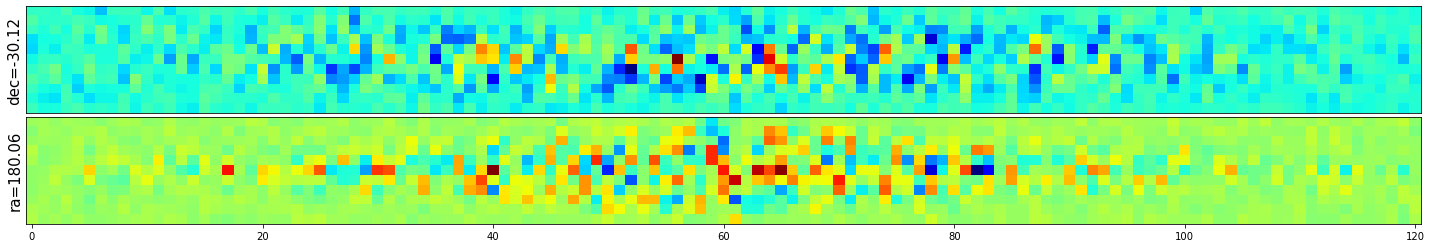

In [13]:
ii = 1500

ds = 5
dff = 60

source = sources.loc[flux_inds[ii]:flux_inds[ii],:]

ra_s = source['ra'].values
dec_s = source['dec'].values
freq_s = source['central_freq'].values

ra_p,dec_p,freq_p = coord_sys.wcs_world2pix(np.array([ra_s,dec_s,freq_s]).reshape(1,3),0).T.astype(int)
ra_p,dec_p,freq_p = ra_p[0],dec_p[0],freq_p[0]
# ra_p,dec_p,freq_p

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(25,4))

patch = psky[freq_p-dff:freq_p+dff+1,dec_p-ds:dec_p+ds+1,ra_p-ds:ra_p+ds+1]
# gpatch = get_patch(patch.shape,axis=0,sigma=0.5,muu=0)
gpatch = get_patch(patch.shape,axis=2,sigma0=0.55,muu=0,c=1.5)
patch.shape,gpatch.shape

# patch = gaussian_filter(patch,(2,2,5))
# patch = patch*gpatch
i = patch
c = gpatch
patch = 0.2*patch+2*gpatch*patch #magnifier(c,b,i,a,d)
print(patch.shape)

ax1.imshow(np.mean(patch,axis=2).T,aspect='auto',cmap='jet', origin='lower')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylabel('dec={:2.2f}'.format(dec_s[0]),fontsize=15)

ax2.imshow(np.mean(patch,axis=1).T,aspect='auto',cmap='jet', origin='lower')
ax2.set_yticks([])
ax2.set_ylabel('ra={:2.2f}'.format(ra_s[0]),fontsize=15)

plt.subplots_adjust(hspace=0.03)

# source

In [14]:
ysky = 0.2*psky

ds = 5
dff = 60

for ii in range(sources.shape[0]):
    print(ii,end='\r')
    source = sources.loc[flux_inds[ii]:flux_inds[ii],:]
    ra_s = source['ra'].values
    dec_s = source['dec'].values
    freq_s = source['central_freq'].values
    ra_p,dec_p,freq_p = coord_sys.wcs_world2pix(np.array([ra_s,dec_s,freq_s]).reshape(1,3),0).T.astype(int)
    ra_p,dec_p,freq_p = ra_p[0],dec_p[0],freq_p[0]
    patch = psky[freq_p-dff:freq_p+dff+1,dec_p-ds:dec_p+ds+1,ra_p-ds:ra_p+ds+1]+0
    
    try:
#         gpatch = get_patch(patch.shape,axis=0,sigma=0.2,muu=0)
        gpatch = get_patch(patch.shape,axis=2,sigma0=0.55,muu=0,c=0.4)
    #     print(ii,patch.shape,gpatch.shape)
        i = patch
        c = gpatch
        patch = 2*gpatch*patch
        ysky[freq_p-dff:freq_p+dff+1,dec_p-ds:dec_p+ds+1,ra_p-ds:ra_p+ds+1] += patch
    except:
        pass


In [15]:
dsmear = 10

psky = psky-psky.min()
psky = psky/psky.max()
psky = np.concatenate([np.zeros((1,643,643)),psky,np.zeros((1,643,643))],axis=0)
psky = smear(psky,0,dsmear)

ysky = ysky-ysky.min()
ysky = ysky/ysky.max()
ysky = np.concatenate([np.zeros((1,643,643)),ysky,np.zeros((1,643,643))],axis=0)
ysky = smear(ysky,0,dsmear)

psky.shape,ysky.shape

((667, 643, 643), (667, 643, 643))

In [16]:
# nadd = (21*(nf//21+1)-nf)//2
# nsmear = (nf//21+1)

# psky = psky-psky.min()
# psky = psky/psky.max()
# psky = np.concatenate([np.zeros((nadd,643,643)),psky,np.zeros((nadd,643,643))],axis=0)

# psky = smear(psky,0,32)
# psky.shape,csky.shape

0.4921132532969682
0.5058177257508718


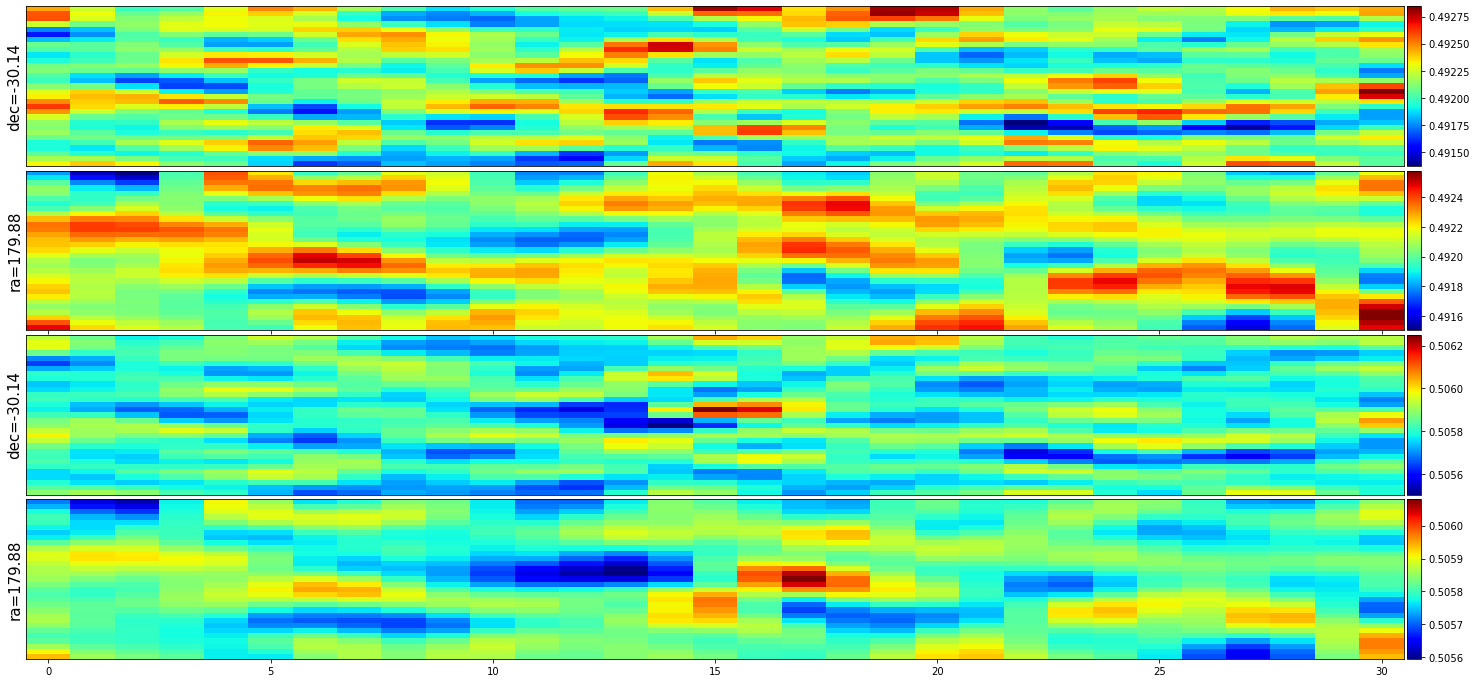

In [17]:
ii = 1000

ds = 15
dff = 15

source = sources.loc[flux_inds[ii]:flux_inds[ii],:]

ra_s = source['ra'].values
dec_s = source['dec'].values
freq_s = source['central_freq'].values

ra_p,dec_p,freq_p = coord_sys.wcs_world2pix(np.array([ra_s,dec_s,freq_s]).reshape(1,3),0).T.astype(int)
ra_p,dec_p,freq_p = ra_p[0],dec_p[0],freq_p[0]//dsmear
# ra_p,dec_p,freq_p

fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(25,12))

patch = psky[freq_p-dff:freq_p+dff+1,dec_p-ds:dec_p+ds+1,ra_p-ds:ra_p+ds+1]
print(patch.mean())
patch = gaussian_filter(patch,(1,1,2))

im = ax1.imshow(np.mean(patch,axis=2).T,aspect='auto',cmap='jet', origin='lower')
ax = ax1
ax.set_ylabel('axis=0',fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='1%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylabel('dec={:2.2f}'.format(dec_s[0]),fontsize=15)

im = ax2.imshow(np.mean(patch,axis=1).T,aspect='auto',cmap='jet', origin='lower')
ax = ax2
ax.set_ylabel('axis=0',fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='1%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax2.set_yticks([])
ax2.set_ylabel('ra={:2.2f}'.format(ra_s[0]),fontsize=15)


patch = ysky[freq_p-dff:freq_p+dff+1,dec_p-ds:dec_p+ds+1,ra_p-ds:ra_p+ds+1]
print(patch.mean())
patch = gaussian_filter(patch,(1,1,2))

im = ax3.imshow(np.mean(patch,axis=2).T,aspect='auto',cmap='jet', origin='lower')
ax = ax3
ax.set_ylabel('axis=0',fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='1%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_ylabel('dec={:2.2f}'.format(dec_s[0]),fontsize=15)

im = ax4.imshow(np.mean(patch,axis=1).T,aspect='auto',cmap='jet', origin='lower')
ax = ax4
ax.set_ylabel('axis=0',fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='1%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax4.set_yticks([])
ax4.set_ylabel('ra={:2.2f}'.format(ra_s[0]),fontsize=15)

plt.subplots_adjust(hspace=0.03)

# source

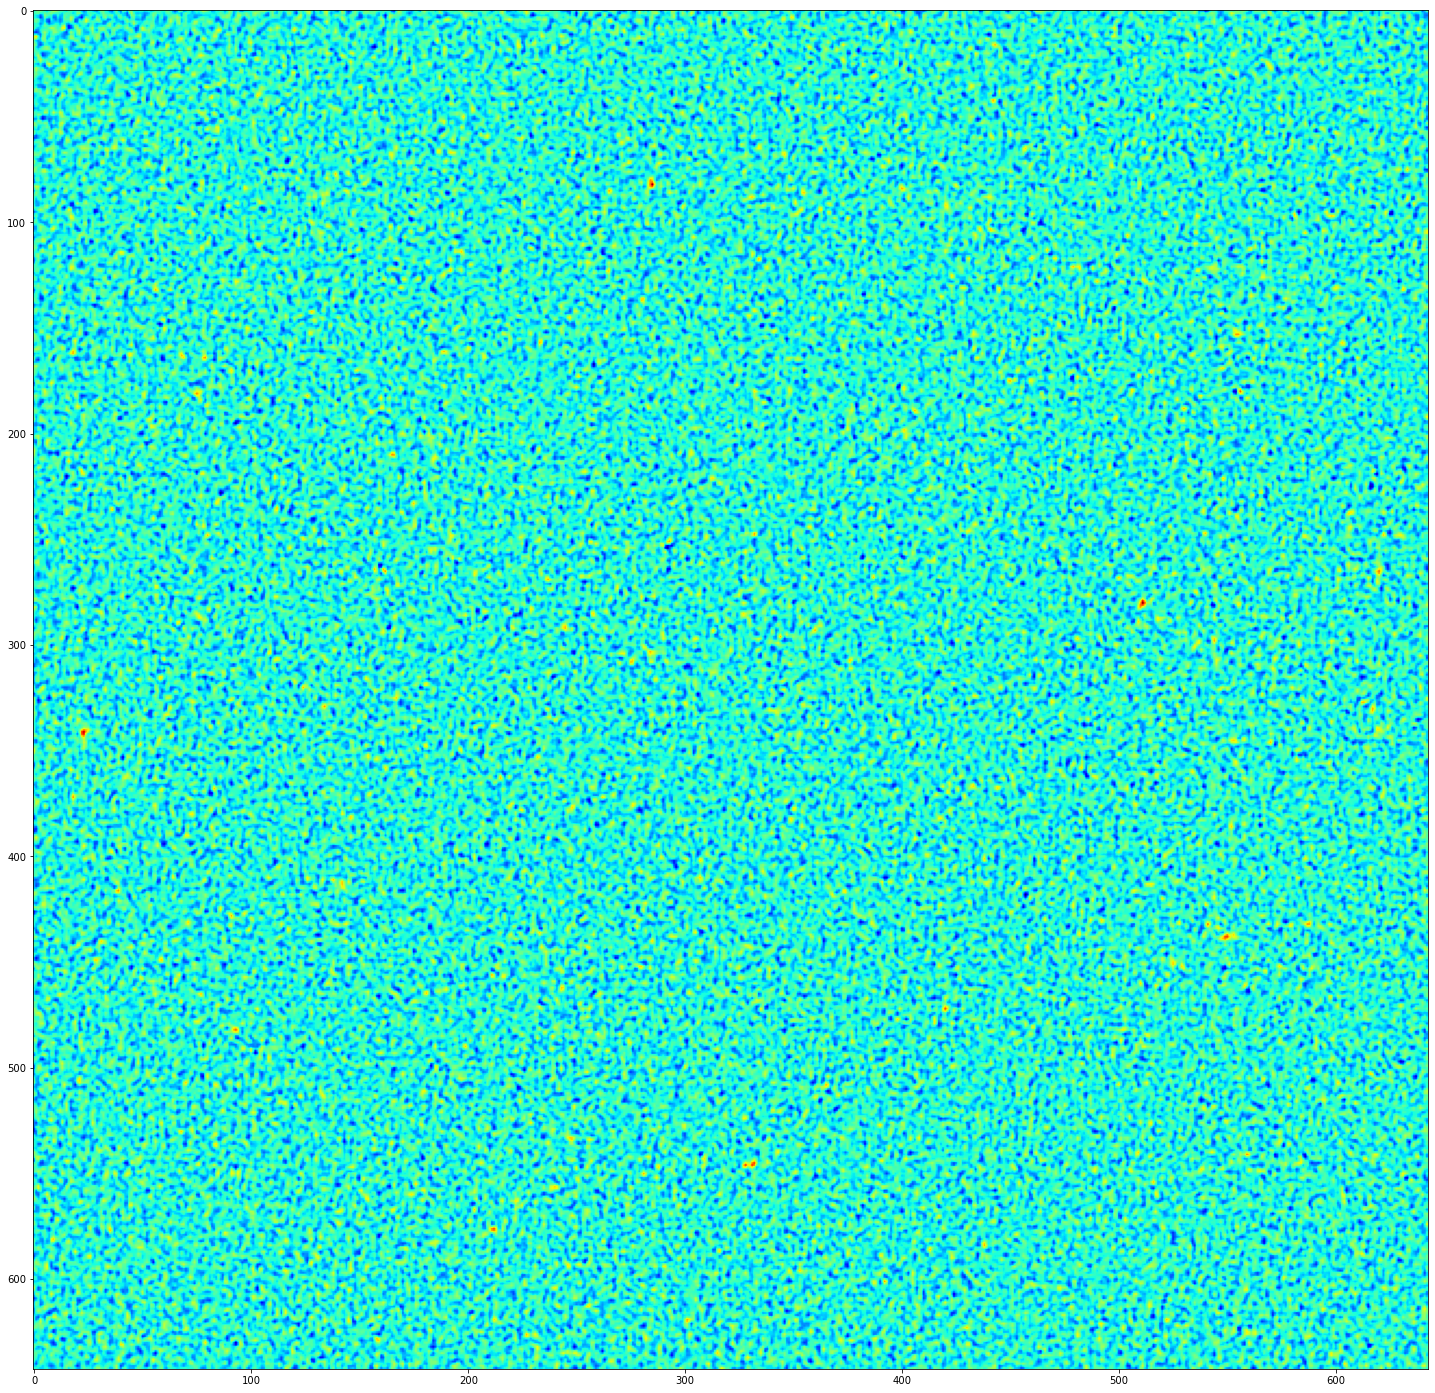

In [18]:
fig,ax = plt.subplots(1,1,figsize=(25,25))
img = np.mean(ysky,axis=0)
# img = gaussian_filter(img,2)
ax.imshow(img,cmap='jet',aspect='auto')

In [19]:
psky.shape,ysky.shape

((667, 643, 643), (667, 643, 643))

In [20]:
psky = np.swapaxes(psky,2,0)
ysky = np.swapaxes(ysky,2,0)
psky.shape,ysky.shape

((643, 643, 667), (643, 643, 667))

In [21]:
nx,ny,nz = 32,32,5
xp,yp = get_slice(psky,ysky,nx,ny,nz)
xp.shape,yp.shape

((32, 32, 5), (32, 32, 5))

In [22]:
nd1,nd2,nch = nx,ny,nz

In [23]:
n_class = nch

model = SimpleConv(shape=(nd1,nd2,nch),n_class=n_class,fgrow=2)
model.summary()
model_name = '2-ska-2d-1.h5'

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 5)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 10)   460         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 10)   910         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 20)   1820        conv2d_1[0][0]                   
______________________________________________________________________________________________

In [105]:
model = keras.models.load_model(model_name)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                             initial_learning_rate=1e-3,
                             decay_steps=50,
                             decay_rate=0.95)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
#     loss=keras.losses.BinaryCrossentropy(),
    loss=keras.losses.MeanSquaredError(),
    optimizer=opt,
    metrics=["accuracy"],
)

In [106]:
psky = psky-psky.min()
psky = psky/psky.max()
ysky = ysky-ysky.min()
ysky = ysky/ysky.max()

In [107]:
def data_provider(n):
    x,y = [],[]
    for i in range(n):
        xp,yp = get_slice(psky,ysky,nx,ny,nz)
        x.append(xp)
        y.append(yp)
    x = np.array(x)
    y = np.array(y)
    return x,y

# class DataProvider():
#     def __init__():
        
    
#     def __call__(n):

#         return 

x,y = data_provider(10)
x.shape,y.shape

((10, 32, 32, 5), (10, 32, 32, 5))

In [108]:
n_iter = psky.size//(nd1*nd2*nch)
n_iter

53861

In [109]:
rept = 'iter: {:5.3f}%   <{:50s}> | epochs: {:3d}/{:3d}'

n_epochs = 1
for epoch in range(n_epochs):
    for i in range(n_iter):
        report = rept.format(100*(i+1)/n_iter,int(50*(i+1)/n_iter)*'=',
                             epoch+1,n_epochs)
        print(report,end='\r')
        x,y = data_provider(10)
        model.train_on_batch(x,y)

model.save(model_name)

In [112]:
ls ~/scratch/ska/

development/  development_large/  evaluation/


In [ ]:
# from time import time

# sky = fits.open(data_path+'sky_{}_v2.fits'.format(dmode))

# axis = 0
# dsss = 400

# data = sky[0].data[:,:dsss,:dsss]+0

# # t0 = time()
# # nd = data.shape[axis]
# # smeared = []
# # for inds in np.array_split(np.arange(0,nd),int(nd/dsmear+1)):
# #     chunk = np.take(data, inds, axis)
# #     smeared.append(np.mean(chunk,axis=axis))
# # smeared = np.stack(smeared,axis=axis)
# # print('CPU, new',time()-t0,smeared.shape)

# t0 = time()
# smeared = np.concatenate([np.zeros((1,dsss,dsss)),data,np.zeros((1,dsss,dsss))],axis=0)
# smeared = smear(smeared,0,dsmear)
# print('CPU, old',time()-t0,smeared.shape)

# t0 = time()
# smeared = jnp.concatenate([jnp.zeros((1,dsss,dsss)),data,jnp.zeros((1,dsss,dsss))],axis=0)
# smeared = jsmear(smeared,0,dsmear)
# print('CPU, old',time()-t0,smeared.shape)

# t0 = time()
# nd = data.shape[axis]
# smeared = []
# for inds in jnp.array_split(jnp.arange(0,nd),int(nd/dsmear+1)):
#     chunk = jnp.take(data, inds, axis)
#     smeared.append(jnp.mean(chunk,axis=axis))
# smeared = jnp.concatenate(smeared,axis=axis)
# print('GPU, new',time()-t0,smeared.shape)

In [28]:
# patches = []
# chars = []
# for ii in range(sources.shape[0]):
#     source = sources.loc[ii,:]
#     ra_s = source['ra']
#     dec_s = source['dec']
#     freq_s = source['central_freq']
#     ra_p,dec_p,freq_p = coord_sys.wcs_world2pix(np.array([ra_s,dec_s,freq_s]).reshape(1,3),0).T.astype(int)
#     ra_p,dec_p,freq_p = ra_p[0],dec_p[0],freq_p[0]
#     patch = psky[freq_p-dff:freq_p+dff+1,dec_p-ds:dec_p+ds+1,ra_p-ds:ra_p+ds+1]
#     if patch.shape!=(2*dff+1,2*ds+1,2*ds+1):
#         continue
    
#     patches.append(patch.T)
#     chars.append(sources.loc[ii,['hi_size','line_flux_integral','pa','i','w20']].values)

# patches = np.array(patches)
# chars = np.array(chars)[:,3:4]
# ndata,nd1,nd2,nd3 = patches.shape
# n_classes = chars.shape[1]
# patches.shape,chars.shape

In [30]:
# data_gen_args = dict(rotation_range=10,
#                      width_shift_range=0.1,
#                      height_shift_range=0.1,
#                      zoom_range=0.05,
#                      horizontal_flip=True,
#                      vertical_flip=True,
#                      preprocessing_function=add_noise,
#                      fill_mode="nearest")

# aug1 = ImageDataGenerator(**data_gen_args)
# aug2 = ImageDataGenerator(**data_gen_args)

# nac = nac_data_set[dname]
# mac = mac_data_set[dname]

# nac_flow = aug1.flow(nac,batch_size=BS,seed=seed)
# mac_flow = aug2.flow(mac,batch_size=BS,seed=seed)
# gen_nac = make_gen(nac_flow)
# gen_mac = make_gen(mac_flow)
# dataset1 = tf.data.Dataset.from_generator(gen_nac,output_types=(tf.float32),output_shapes=(None,nd1,nd2,nd3))
# dataset2 = tf.data.Dataset.from_generator(gen_mac,output_types=(tf.float32),output_shapes=(None,nd1,nd2,nd3))
# dataset3 = tf.data.Dataset.zip((dataset1, dataset2))#.batch(10)

# federated_train_data.append(dataset3)

# xample,yample = dataset.batch(10)
# for e1,e2 in flow:
#     print(e1.shape,e2.shape)
#     break

# fig,ax = plt.subplots(1,1,figsize=(8,3*nd3))

# i = np.random.randint(e1.shape[0])
# ax.imshow(e1[i,:,:,:].mean(axis=-1))
# ax.axis('off')
# ax.axis('off')

In [31]:
class ZeroPadding3DChannels(layers.Layer):
    """Pad the last dimension of a 5D tensor symmetrically with zeros.
    This is meant for 3D convolutions, where tensors are 5D.
    """

    def __init__(self, padding, **kwds):
        self.padding = padding
        # batch, x, y, z, channels
        self._paddings = [[0, 0], [0, 0], [0, 0], [0, 0], [self.padding, self.padding]]
        super(ZeroPadding3DChannels, self).__init__(**kwds)

    def call(self, x):
        return tf.pad(x, paddings=self._paddings, mode='CONSTANT', constant_values=0)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'padding': self.padding 
        })
        return config

def HighRes3DNet(input_shape, n_classes=1, activation="relu", dropout_rate=0, name="highresnet"):
    """Instantiate HighResNet model."""

    conv_kwds = {"kernel_size": (3, 3, 3), "padding": "same"}
    
    n_repeat = 1
    n_base_filters = 4

    inputs = layers.Input(shape=input_shape)
    x = tf.expand_dims(inputs,-1)
    x = layers.Conv3D(n_base_filters, **conv_kwds)(x)

    for ii in range(n_repeat):
        skip = x
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.Conv3D(n_base_filters, **conv_kwds)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.Conv3D(n_base_filters, **conv_kwds)(x)
        x = layers.Add()([x, skip])
        
#         x = layers.MaxPooling2D((2, 2))(x)

    x = ZeroPadding3DChannels(n_base_filters//2)(x)
    for ii in range(n_repeat):
        skip = x
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.Conv3D(n_base_filters * 2, dilation_rate=2, **conv_kwds)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.Conv3D(n_base_filters * 2, dilation_rate=2, **conv_kwds)(x)
        x = layers.Add()([x, skip])
        
#         x = layers.MaxPooling2D((2, 2))(x)

    x = ZeroPadding3DChannels(n_base_filters)(x)
    for ii in range(n_repeat):
        skip = x
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.Conv3D(n_base_filters * 4, dilation_rate=4, **conv_kwds)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.Conv3D(n_base_filters * 4, dilation_rate=4, **conv_kwds)(x)
        x = layers.Add()([x, skip])
        
#         x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv3D(filters=n_classes, kernel_size=(1, 1, 1), padding="same")(x)

#     final_activation = "sigmoid" if n_classes == 1 else "softmax"
    final_activation = "relu"
    x = layers.Activation(final_activation)(x)
    x = tf.squeeze(x,4)
    
#     x = layers.Flatten()(x)

#     x = layers.Dense(n_latent, activation="relu")(x)
#     x = layers.Dropout(0.6)(x)
#     out = layers.Dense(n_class, activation="softmax",activity_regularizer=regularizers.l1(l1))(x)


    # QUESTION: where should dropout go?

    return tf.keras.Model(inputs=inputs, outputs=x, name=name) 

# model = HighRes3DNet(input_shape=(nd1,nd2,nd3))
# model.compile(
#     optimizer=keras.optimizers.RMSprop(),  # Optimizer
#     # Loss function to minimize
#     loss=keras.losses.MeanSquaredError(),
#     # List of metrics to monitor
# #     metrics=[keras.metrics.SparseCategoricalAccuracy()],
# )

model = keras.models.load_model('mag1.h5',custom_objects={"ZeroPadding3DChannels":ZeroPadding3DChannels})

model.summary(line_length=120,positions=[.33, .55, .67, 1.])

Model: "highresnet"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input_1 (InputLayer)                   [(None, 80, 5, 5)]         0                                                     
________________________________________________________________________________________________________________________
tf.expand_dims (TFOpLambda)            (None, 80, 5, 5, 1)        0             input_1[0][0]                           
________________________________________________________________________________________________________________________
conv3d (Conv3D)                        (None, 80, 5, 5, 4)        112           tf.expand_dims[0][0]                    
________________________________________________________________________________________________________________________
batch_normal

In [32]:
psky = psky-psky.min()
psky = psky/psky.max()
ysky = ysky-ysky.min()
ysky = ysky/ysky.max()

In [33]:
nx,ny,nz = 80,5,5
xp,yp = get_slice(psky,ysky,nx,ny,nz)
xp.shape,yp.shape

((80, 5, 5), (80, 5, 5))

In [110]:
class ZeroPadding3DChannels(layers.Layer):
    """Pad the last dimension of a 5D tensor symmetrically with zeros.
    This is meant for 3D convolutions, where tensors are 5D.
    """

    def __init__(self, padding, **kwds):
        self.padding = padding
        # batch, x, y, z, channels
        self._paddings = [[0, 0], [0, 0], [0, 0], [0, 0], [self.padding, self.padding]]
        super(ZeroPadding3DChannels, self).__init__(**kwds)

    def call(self, x):
        return tf.pad(x, paddings=self._paddings, mode='CONSTANT', constant_values=0)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'padding': self.padding 
        })
        return config

def HighRes3DNetClassifier(input_shape, n_classes=1, activation="relu", l1=1e-10, dropout_rate=0, name="highresnet"):
    """Instantiate HighResNet model."""

    conv_kwds = {"kernel_size": (3, 3, 3), "padding": "same"}
    
    n_repeat = 3
    n_base_filters = 4

    inputs = layers.Input(shape=input_shape)
    x = tf.expand_dims(inputs,-1)
    x = layers.Conv3D(n_base_filters, **conv_kwds)(x)

    for ii in range(n_repeat):
        skip = x
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters, **conv_kwds)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.Conv3D(n_base_filters, **conv_kwds)(x)
        x = layers.Add()([x, skip])

        x = layers.MaxPooling3D((2, 2, 4))(x)

#     x = ZeroPadding3DChannels(n_base_filters//2)(x)
#     for ii in range(n_repeat):
#         skip = x
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 2, dilation_rate=2, **conv_kwds)(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 2, dilation_rate=2, **conv_kwds)(x)
#         x = layers.Add()([x, skip])
        
# #         x = layers.MaxPooling2D((2, 2))(x)

#     x = ZeroPadding3DChannels(n_base_filters)(x)
#     for ii in range(n_repeat):
#         skip = x
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 4, dilation_rate=4, **conv_kwds)(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 4, dilation_rate=4, **conv_kwds)(x)
#         x = layers.Add()([x, skip])
        
#         x = layers.MaxPooling2D((2, 2))(x)


    sh = x.shape[1:]
#     print(sh)
    x = layers.Flatten()(x)

    x = layers.Dense(np.prod(sh)//2, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(n_classes, activation="linear")(x)

#     x = layers.Conv3D(filters=n_classes, kernel_size=(1, 1, 1), padding="same")(x)

#     final_activation = "sigmoid" if n_classes == 1 else "softmax"
#     final_activation = "relu"
#     x = layers.Activation(final_activation)(x)
#     x = tf.squeeze(x,-1)
    
#     x = layers.Flatten()(x)

#     x = layers.Dense(n_latent, activation="relu")(x)
#     x = layers.Dropout(0.6)(x)
#     out = layers.Dense(n_class, activation="softmax",activity_regularizer=regularizers.l1(l1))(x)


    # QUESTION: where should dropout go?
    model = keras.Model(inputs=inputs, outputs=x, name=name) 

    model.compile(
    #     loss=keras.losses.BinaryCrossentropy(),
        loss=keras.losses.MeanSquaredError(),
        optimizer='adam',
        metrics=["accuracy"],
    )
    return model

# model0 = HighRes3DNetClassifier(input_shape=(nd1,nd2,nd3), n_classes=n_classes)
# model0.summary(line_length=120,positions=[.33, .55, .67, 1.])

In [111]:
# X_train, X_test, y_train, y_test = train_test_split(patches,chars_norm, test_size=0.2, random_state=42)

# plt.hist(np.log(y_train[:,1]+1e-3))

In [112]:
models = []
fluxmins = []
# topw = np.array([500,700,1000,1500,2000,y_train.shape[0]])
topw = np.array([y_train.shape[0]])

for i in range(len(topw)):
#     filt = trsh<np.log(y_train[:,1]+1e-5)
#     flux = y_train[:,1]
#     inds = np.argsort(flux)[::-1]
#     inds = inds[:topw[i]]
#     fluxmin = np.min(y_train[inds,1])
#     print(i,fluxmin)
#     fluxmins.append(fluxmin)
    data_gen_args = dict(rotation_range=10,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.05,
                         horizontal_flip=True,
                         vertical_flip=True,
                         preprocessing_function=add_noise,
                         fill_mode="nearest")

    aug = ImageDataGenerator(**data_gen_args)
    print(X_train[inds].shape,y_train[inds].shape)
    flow = aug.flow(X_train[inds],y_train[inds],batch_size=32,seed=0)
    batch_size = 32
    
    model = HighRes3DNetClassifier(input_shape=(nd1,nd2,nd3), n_classes=n_classes)
    history = model.fit(flow,
                        steps_per_epoch=X_train[inds].shape[0] // batch_size,
                        epochs=150,
                        verbose=0)
    
    models.append(model)

(773, 21, 21, 121) (773, 1)


In [113]:
# # for i,fluxmin in enumerate(fluxmins):
# #     filt1 = fluxmin<y_train[:,1]
# #     filt = fluxmin<y_test[:,1]
# #     print(filt1.sum(),filt.sum())



# r2s = []

# for i,fluxmin in enumerate(fluxmins):
# #     filt = fluxmin<y_test[:,1]
#     data_gen_args = dict(rotation_range=10,
#                          width_shift_range=0.1,
#                          height_shift_range=0.1,
#                          zoom_range=0.05,
#                          horizontal_flip=True,
#                          vertical_flip=True,
#                          preprocessing_function=add_noise,
#                          fill_mode="nearest")

# #     aug = ImageDataGenerator(**data_gen_args)
# #     flow = aug.flow(X_test[filt],y_test[filt],batch_size=32,seed=0)
# #     batch_size = 32

#     model = models[i]
    
#     y_pred = model.predict(X_test)
#     rp = []
#     for j in range(n_classes): 
#         rp.append(r2_score(y_test[:,j],y_pred[:,j]))
#     r2s.append(rp)
# r2s = np.array(r2s)
# print(r2s)

In [114]:
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     vertical_flip=True,
                     preprocessing_function=add_noise,
                     fill_mode="nearest")

#     aug = ImageDataGenerator(**data_gen_args)
#     flow = aug.flow(X_test[filt],y_test[filt],batch_size=32,seed=0)
#     batch_size = 32

model = models[0]

y_pred = model.predict(X_test)
rp = []
for j in range(n_classes): 
    print(r2_score(y_test[:,j],y_pred[:,j]))

-0.012581847198845253


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

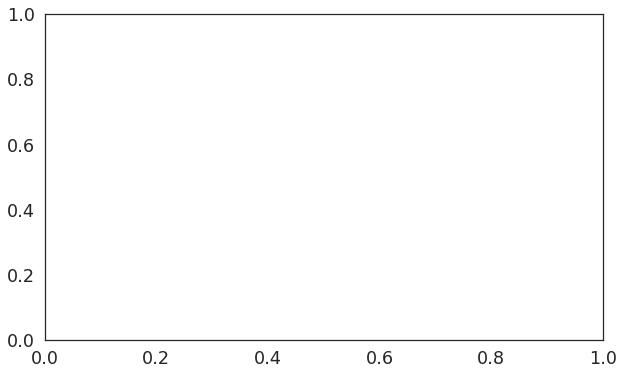

In [63]:
lbls = ['hi_size','line_flux_integral','pa','i','w20']

fig,ax = plt.subplots(1,1,figsize=(10,6))

for i in range(n_classes):
    ax.plot(fluxmins,r2s[:,i],label=lbls[i])
    
ax.set_ylim(-2,1)
ax.legend(loc=(1,0.6))

(array([ 9., 27., 56., 62., 31.,  7.,  0.,  0.,  1.,  1.]),
 array([0.62516844, 0.6251741 , 0.62517977, 0.62518543, 0.6251911 ,
        0.6251967 , 0.62520236, 0.625208  , 0.6252137 , 0.62521935,
        0.625225  ], dtype=float32),
 <BarContainer object of 10 artists>)

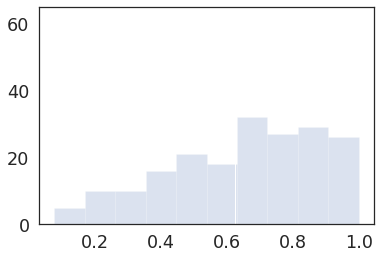

In [39]:
j = 3

plt.hist(y_test[:,j],color='b',alpha=0.2)
plt.hist(y_pred[:,j],color='r')

In [40]:
# y_pred[:,j]

In [41]:
1

1

In [42]:
def build_model_2dconv(shape, n_class, n_latent=64, n_layers=1, kernel_size=3, pooling_size=2, l1=1e-10):

    
    inp = keras.Input(shape=shape, name="input")

    x = layers.Conv2D(16, (kernel_size, kernel_size), activation='relu', padding='same', activity_regularizer=regularizers.l1(l1))(inp)
    x = layers.MaxPooling2D((pooling_size, pooling_size), padding='same')(x)
    
    for _ in range(n_layers):
        x = layers.Conv2D(8, (kernel_size, kernel_size), activation='relu', padding='same', activity_regularizer=regularizers.l1(l1))(x)
        x = layers.MaxPooling2D((pooling_size, pooling_size), padding='same')(x)

    sh = x.shape[1:]
#     print(sh)
    x = layers.Flatten()(x)

    latent = layers.Dense(n_latent, activation="relu")(x)
    dop = layers.Dropout(0.6)(latent)
    out = layers.Dense(n_class, activation="softmax",activity_regularizer=regularizers.l1(l1))(dop)

#     x = layers.Dense(2, activation='softmax',
#                 activity_regularizer=regularizers.l1(l1))(x)
    
    
    
    
    
#     inp = keras.Input(shape=shape, name="input")
#     x = layers.Dense(128, activation="relu")(inp)
#     latent = layers.Dense(n_latent, activation="relu")(x)
#     dop = layers.Dropout(0.6)(latent)
#     out = layers.Dense(n_class, activation="softmax")(dop)
#     # out = layers.Dense(n_class, activation="sigmoid")(dop)


    clf = keras.Model(inputs=inp, outputs=out, name="Classifier")
    drt = keras.Model(inputs=inp, outputs=latent, name="DimensionalityReducer")

#     clf.summary()

    clf.compile(
    #     loss=keras.losses.BinaryCrossentropy(),
        loss=keras.losses.CategoricalCrossentropy(),
        optimizer='adam',
        metrics=["accuracy"],
    )
    return clf,drt